# Seq2Seq Sales Only

In [2]:
from sklearn.metrics import mean_absolute_error

import os
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from datetime import timedelta

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

# seq2seq model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
# from google.colab import drive, files
# drive.mount('/content/gdrive')
%matplotlib inline

import seaborn as sns
sns.set()

# os.chdir('gdrive/My Drive/web_traffic_tut_gdrive')

# df = pd.read_csv('data/raw/train_final.csv')

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if np.isfinite(mape):
        return mape
    else:
        return np.NaN

In [5]:
! ls ../data/

all_sales_df.pkl  item_tensors.npz  promo_tensors.npz	    store_tensors.npz
dt_tensors.npz	  oil_tensors.npz   store_item_tensors.npz


In [6]:
df = pd.read_pickle('../data/all_sales_df.pkl')

In [7]:
df.head()

date,store_item,2013-03-16 00:00:00,2013-03-17 00:00:00,2013-03-18 00:00:00,2013-03-19 00:00:00,2013-03-20 00:00:00,2013-03-21 00:00:00,2013-03-22 00:00:00,2013-03-23 00:00:00,2013-03-24 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
0,store_47_item_581078,57.0,66.0,31.0,28.0,29.0,29.0,41.0,54.0,60.0,...,114.0,55.0,40.0,53.0,54.0,111.0,99.0,131.0,109.0,72.0
1,store_46_item_265559,186.0,287.0,136.0,106.0,104.0,71.0,73.0,207.0,228.0,...,204.0,89.0,65.0,71.0,67.0,109.0,241.0,260.0,122.0,160.0
2,store_37_item_364606,83.0,64.0,76.0,42.0,81.0,33.0,46.0,73.0,38.0,...,33.0,18.0,21.0,24.0,17.0,30.0,37.0,35.0,30.0,32.0
3,store_46_item_213652,25.0,40.0,13.0,11.0,20.0,6.0,11.0,29.0,20.0,...,17.0,9.0,2.0,14.0,8.0,16.0,32.0,29.0,8.0,11.0
4,store_46_item_213788,28.0,34.0,13.0,18.0,13.0,10.0,21.0,25.0,37.0,...,17.0,9.0,3.0,6.0,14.0,13.0,9.0,25.0,3.0,11.0


In [8]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2013-03-16 00:00:00 to 2017-07-04 00:00:00


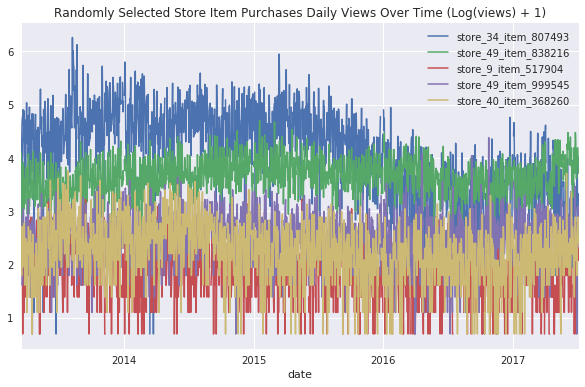

In [9]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    store_item_labels = sample['store_item'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Store Item Purchases Daily Views Over Time (Log(views) + 1)')
    plt.legend(store_item_labels)
    
plot_random_series(df, 5)

In [10]:
# predict the next week
pred_steps = 28 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2013-03-16 00:00:00 - 2017-05-09 00:00:00
Train prediction: 2017-05-10 00:00:00 - 2017-06-06 00:00:00 

Val encoding: 2013-04-13 00:00:00 - 2017-06-06 00:00:00
Val prediction: 2017-06-07 00:00:00 - 2017-07-04 00:00:00

Encoding interval: 1516
Prediction interval: 28


In [11]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [12]:
# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

model.summary()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

In [13]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=50)

In [14]:
first_n_samples = len(df)
batch_size = 200
epochs = 1000

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, train_enc_start, train_enc_end)[:first_n_samples]

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2, callbacks=[early_stop])  
                

Instructions for updating:
Use tf.cast instead.
Train on 6972 samples, validate on 1743 samples
Epoch 1/1000
6972/6972 [==============================] - 73s 10ms/step - loss: 0.4554 - val_loss: 0.4909
Epoch 2/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.4048 - val_loss: 0.4702
Epoch 3/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3897 - val_loss: 0.4638
Epoch 4/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3827 - val_loss: 0.4588
Epoch 5/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3790 - val_loss: 0.4563
Epoch 6/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3765 - val_loss: 0.4543
Epoch 7/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3761 - val_loss: 0.4546
Epoch 8/1000
6972/6972 [==============================] - 27s 4ms/step - loss: 0.3730 - val_loss: 0.4522
Epoch 9/1000
6972/6972 [==============================] - 27s 4

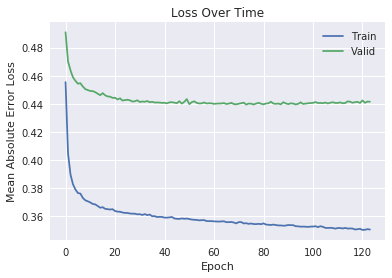

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Visualize Predictions Between val_pred_start, val_pred_end

In [20]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, actual, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(30,6))   
    
    if actual:
      # target is in orange and transformed by adding the mean and then expm1
      plt.plot(pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), np.expm1(target_series + encode_series_mean[sample_ind]),color='orange')
      # teal is forecast
      plt.plot(pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), np.expm1(pred_series + encode_series_mean[sample_ind]),color='teal',linestyle='--')
      # blue is the training a certain amount of days before validation starts
      plt.plot(pd.date_range(start=val_enc_start, end=val_enc_end+timedelta(1),freq='D')[-(x_encode+1):][1:], np.expm1(encode_series_tail + encode_series_mean[sample_ind] ))
    
    else:
      plt.plot(range(1,x_encode+1),encode_series_tail)
      plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
      plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    
    display(pd.DataFrame({'ds': pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), 
              'actual': np.expm1(target_series + encode_series_mean[sample_ind]).flatten(),
              'pred': np.expm1(pred_series + encode_series_mean[sample_ind]).flatten()
             }).set_index('ds').T)

# predict_and_plot(encoder_input_data, decoder_target_data, 0, actual=1)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,30.000000,19.000000,48.000000,43.000000,45.000000,26.000000,26.000000,32.000000,32.000000,50.000000,...,114.000000,55.000000,40.000000,53.000000,54.000000,111.000000,99.000000,131.000000,109.000000,72.000000
pred,39.251704,36.627112,38.561526,44.491076,62.031376,41.699872,33.162767,35.368927,36.393718,41.986625,...,51.930675,40.428124,38.630458,38.432524,33.270509,46.260979,57.542723,63.135439,50.069801,39.168616


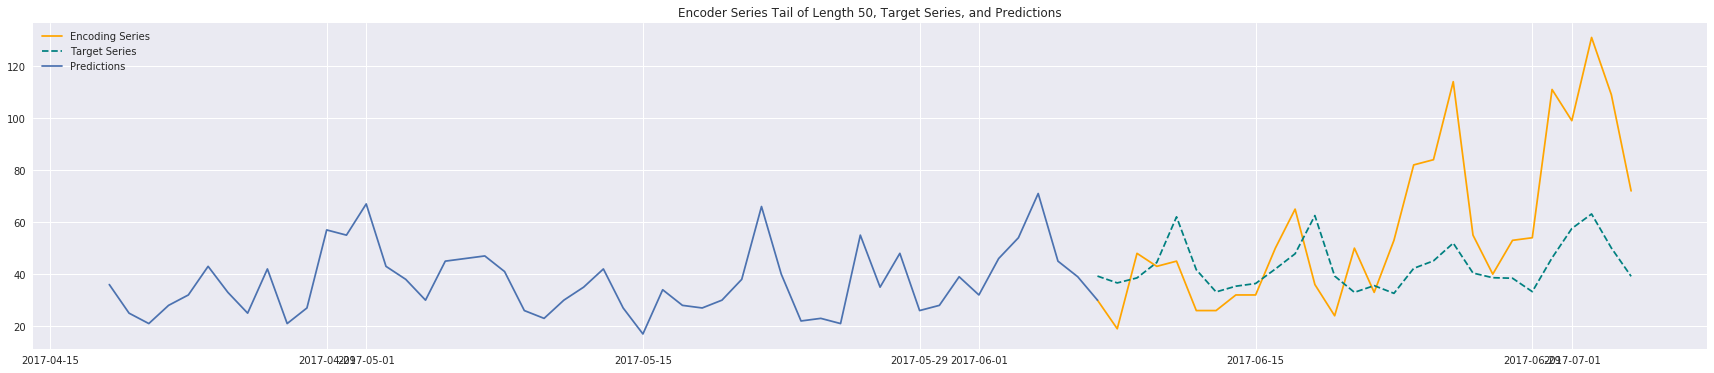

In [21]:
predict_and_plot(encoder_input_data, decoder_target_data, 0, actual=1)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,90.000000,95.000000,86.000000,159.000000,226.000000,87.000000,62.000000,71.000000,87.000000,117.00000,...,204.000000,89.00000,65.000000,71.000000,67.000000,109.000000,241.000000,260.000000,122.000000,160.000000
pred,82.261267,98.037404,82.059812,143.452347,201.743977,118.886454,97.024728,88.435727,88.671488,106.50902,...,189.960981,114.08385,96.853049,96.686438,97.092315,116.227662,192.698276,214.643342,131.043282,115.029518


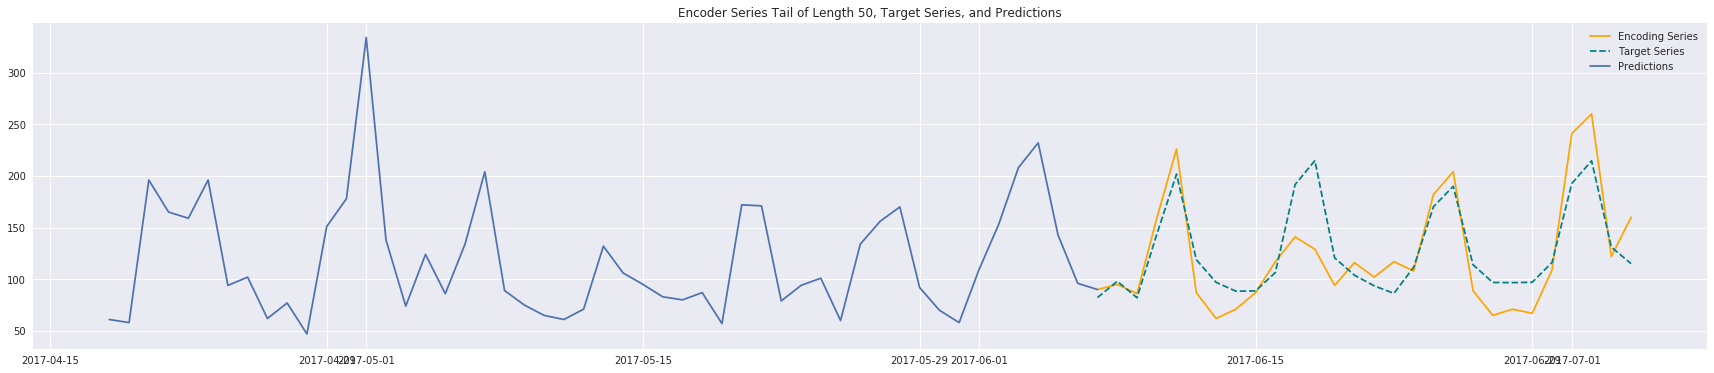

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data, 1, actual=2)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,31.000000,32.000000,15.000000,28.000000,26.000000,33.000000,30.000000,33.000000,22.000000,26.000000,...,33.000000,18.000000,21.000000,24.000000,17.000000,30.00000,37.000000,35.000000,30.00000,32.000000
pred,34.601379,32.026147,28.340943,28.347766,23.744911,30.834391,28.071041,33.024842,31.598478,32.554621,...,25.364641,27.748559,31.097289,29.515901,30.444219,32.12316,34.400132,32.513296,34.59288,36.553618


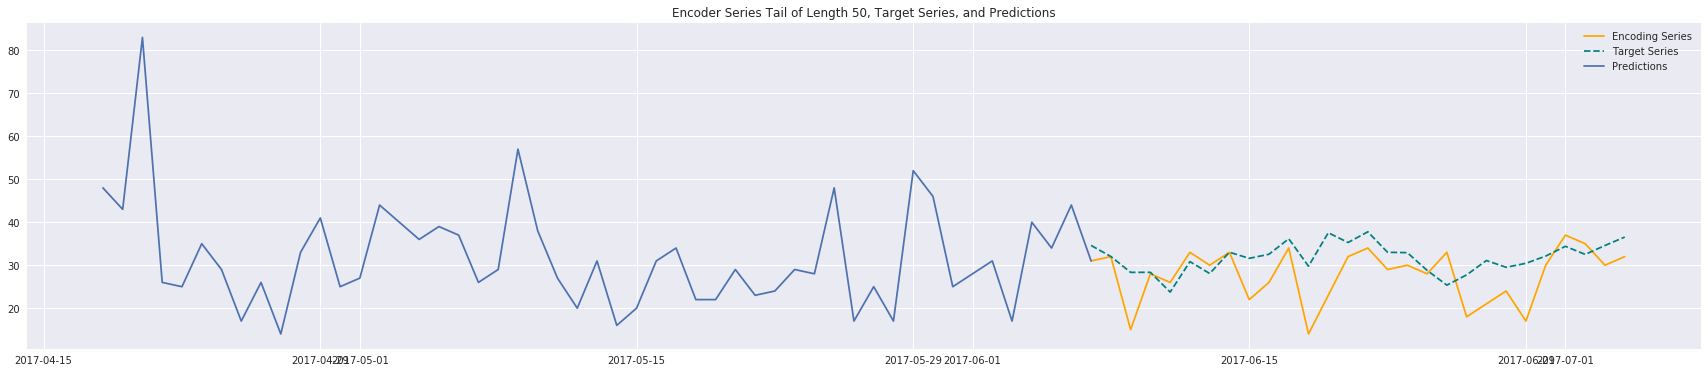

In [23]:
predict_and_plot(encoder_input_data, decoder_target_data, 2, actual=2)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,8.000000,12.000000,6.000000,18.000000,27.000000,7.000000,9.000000,8.000000,13.000000,17.000000,...,17.000000,9.00000,2.000000,14.000000,8.000000,16.000000,32.000000,29.000000,8.000000,11.000000
pred,10.603079,10.067785,12.211938,16.484191,21.336688,12.643412,9.521707,7.220352,9.396486,12.008519,...,18.764976,10.97442,10.628535,10.065088,8.702874,13.354753,18.100222,17.693583,12.961408,10.161911


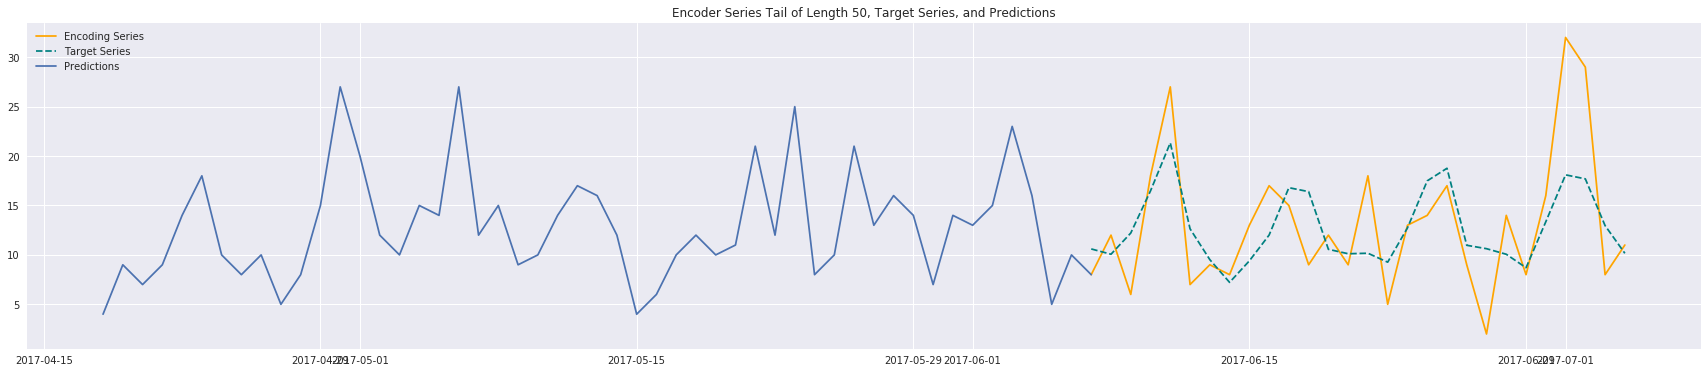

In [24]:
predict_and_plot(encoder_input_data, decoder_target_data, 3, actual=2)

In [84]:
def generate_val_pred_start_end_results(sample_ind):
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)

    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 

    name = df['store_item'][sample_ind]
    raw_df = pd.DataFrame({
        'date': df.columns[-pred_steps:], 
        'actual': np.expm1(target_series + encode_series_mean[sample_ind]).flatten(),
        'pred': np.expm1(pred_series + encode_series_mean[sample_ind]).flatten()}
    )

    mae = mean_absolute_error(raw_df['actual'],raw_df['pred'])
    mape = mean_absolute_percentage_error(raw_df['actual'],raw_df['pred'])

    results = pd.DataFrame({
        'name': name,
        'mae': mae,
        'mape': mape,

    }, index=[sample_ind])


    results['raw'] = [raw_df]
    
    return results

In [97]:
val_results_df=pd.concat([generate_val_pred_start_end_results(sample_ind) for sample_ind in df.index])

In [98]:
val_results_df.describe()

,mae,mape
count,8715.000000,7772.000000
mean,6.153596,49.430281
std,7.567551,37.343630
min,0.226949,5.687923
25%,2.637859,28.846769
50%,4.054980,39.518471
75%,6.849036,56.963518
max,208.750225,769.730727
